# Mini Projeto MLP

###Grupo

*   Camila Vieira
*   Dayane Lira
*   José Vinicius



###Objetivo
Verificar como a alteração de parâmtros (número de camadas, número de unidades, taxa de aprendizagem, funções de ativação, dropout, regularização, etc) interfere no resultado do experimento (os testes serão realizados com o Conjunto de Dados de Sintomas de Lombalgia disponível no Kaggle), utilizando sklearn.neural_network.MLPClassifier.
Importante avaliar os dados, ver normalização e eliminar atributos identificadores. Medir acurácia, matriz de confusão, precision, recall.

##Importações e Downloads

In [ ]:
!pip install scikit-optimize

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from skopt.optimizer import gbrt_minimize
from skopt.space.space import Categorical, Integer, Real
from skopt.utils import use_named_args
from imblearn.over_sampling import SMOTE

##Preparando os dados

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/backpain/Dataset_spine.csv")
df.drop([df.columns[-1]],axis=1,inplace=True)
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal


Pelo dicionário de dados, sabemos que:
*   Col1 - pelvic_incidence
*   Col2 - pelvic tilt
*   Col3 - lumbar_lordosis_angle
*   Col4 - sacral_slope
*   Col5 - pelvic_radius
*   Col6 - degree_spondylolisthesis
*   Col7 - pelvic_slope
*   Col8 - direct_tilt
*   Col9 - thoracic_slope
*   Col10 - cervical_tilt
*   Col11 - sacrum_angle
*   Col12 - scoliosis_slope
*   Class_att - Abnormal, Normal (Normality)

Por meio dos doze primeiros atributos, iremos prever o último.

In [5]:
#Renomeando colunas
new_columns = ['pelvic_incidence','pelvic_tilt','lumbar_lordosis_angle',
        'sacral_slope','pelvic_radius','degree_spondylolisthesis',
        'pelvic_slope','direct_tilt','thoracic_slope','cervical_tilt',
        'sacrum_angle','scoliosis_slope','normality']

df.columns = new_columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt               310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   pelvic_slope              310 non-null    float64
 7   direct_tilt               310 non-null    float64
 8   thoracic_slope            310 non-null    float64
 9   cervical_tilt             310 non-null    float64
 10  sacrum_angle              310 non-null    float64
 11  scoliosis_slope           310 non-null    float64
 12  normality                 310 non-null    object 
dtypes: float64(12), object(1)
memory usage: 31.6+ KB


Os dados estão completos, sem campos NaN. Os atributos são todos do tipo númerico, no entanto o target é do tipo object.

In [6]:
df["normality"].value_counts()

Abnormal    210
Normal      100
Name: normality, dtype: int64

In [7]:
#Transformar o último campo com encoder para 0 (Abnormal) e 1 (Normal)
label_encoder = LabelEncoder()
df["normality"] = label_encoder.fit_transform(df["normality"])
df["normality"].value_counts()

0    210
1    100
Name: normality, dtype: int64

In [8]:
#Separar atributos e label
x = df.iloc[:, :-1]
y = df["normality"]

##Análise Exploratória dos Dados e Pré-Processamento

###Verificar eficácia sem pré-processamento

In [9]:
def estimar_loss(x, y):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15,random_state=42, shuffle=True)
  #Modelo com valores usuais
  mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001,
                                batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5,
                                max_iter=200, shuffle=True, random_state=42, tol=0.0001, verbose=False,
                                warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False,
                                validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10,
                                max_fun=15000)
  #Treinando
  mlp_classifier.fit(x_train, y_train)
  print("Loss do MLP Classifier:", np.mean(mlp_classifier.loss_))

#Avaliação Iterativa: A loss será avaliada em cada estágio do pré-processamento, para entender como cada etapa afeta o desempenho do modelo
#Loss não será usada para melhorar o pré-processamento, apenas ilustrar o desempenho

In [10]:
estimar_loss(x,y)

Loss do MLP Classifier: 0.27808027948957015


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


###Retirando Outliers

**Box Plot**

Os box plots são úteis para visualizar a distribuição de valores em cada característica, mostrando a mediana, quartis e outliers. Isso ajuda a identificar discrepâncias nos dados que podem afetar a modelagem.

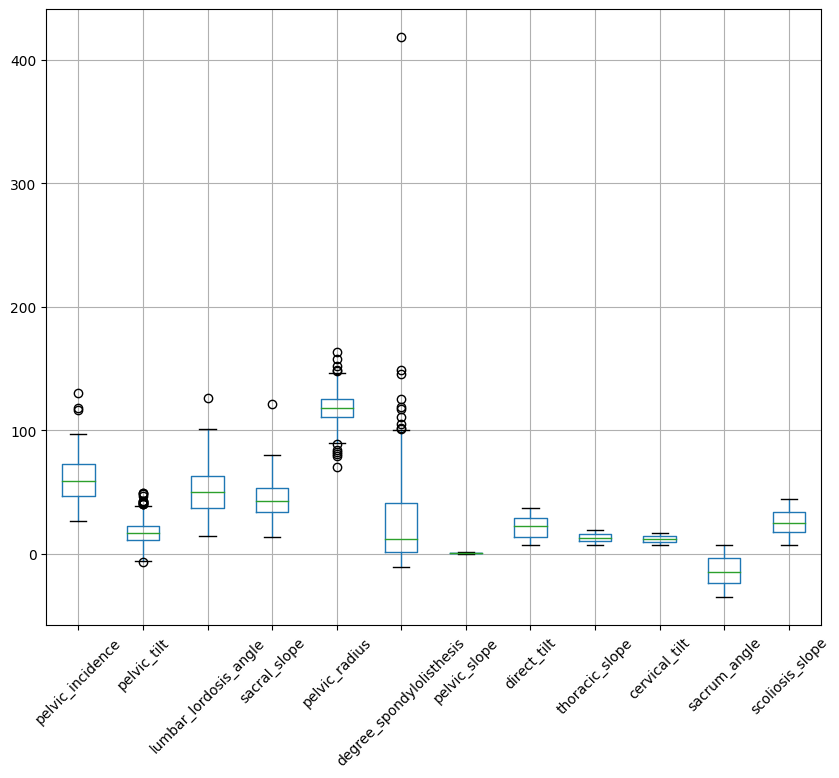

In [11]:
#Box plot
plt.figure(figsize=(10, 8))
x.boxplot()
plt.xticks(rotation=45)
plt.show()

Em um conjunto de dados relativamente pequeno, observamos pelo box plot que a maioria dos outliers está localizada nas proximidades das margens do Intervalo Interquartil (IQR). A abordagem padrão para identificar outliers é a regra dos 1,5 vezes o IQR, mas optamos por aumentar o fator multiplicador para 2, devido ao seu tamanho limitado e à distribuição observada dos outliers.

In [12]:
#Retirada de outliers
df_clean = df.copy()
for col in x:
  lower_bound = df_clean[col].quantile(0.25) - 2 * (df_clean[col].quantile(0.75) - df_clean[col].quantile(0.25))
  upper_bound = df_clean[col].quantile(0.75) + 2 * (df_clean[col].quantile(0.75) - df_clean[col].quantile(0.25))
  df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
x_clean = df_clean.iloc[:, :-1]
y_clean = df_clean["normality"]
estimar_loss(x_clean, y_clean)

Loss do MLP Classifier: 0.30581135424572015


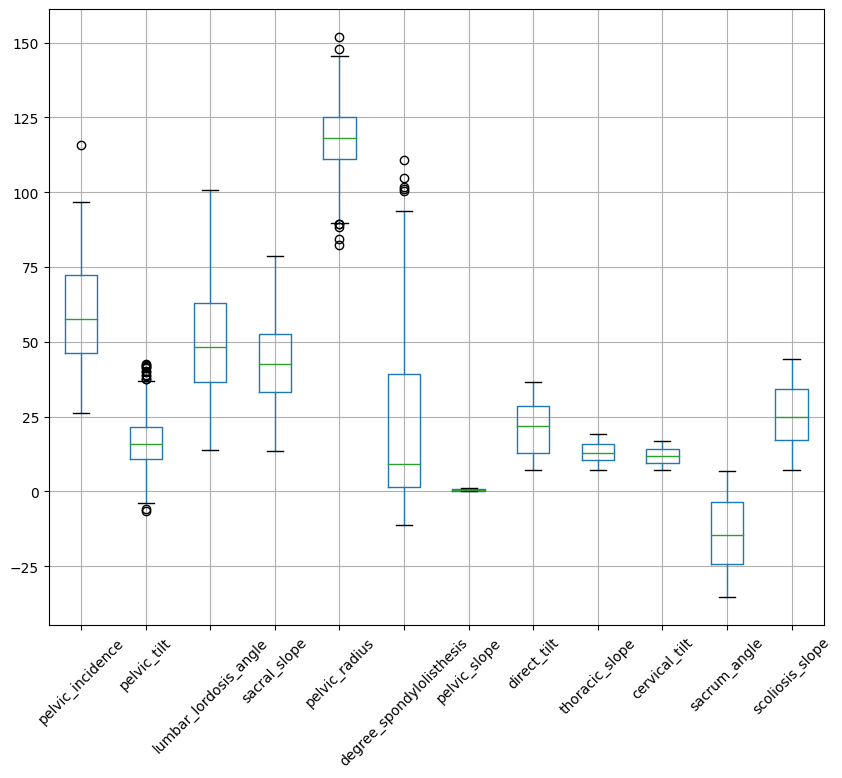

In [13]:
#Box plot
plt.figure(figsize=(10, 8))
x_clean.boxplot()
plt.xticks(rotation=45)
plt.show()

###Balanceamento de classes

**Análise dos Atributos Binários**

Gráfico de contagem adequado para atributos binários, mostra a distribuição da variável. Relevante para entender o equilíbrio da classe.

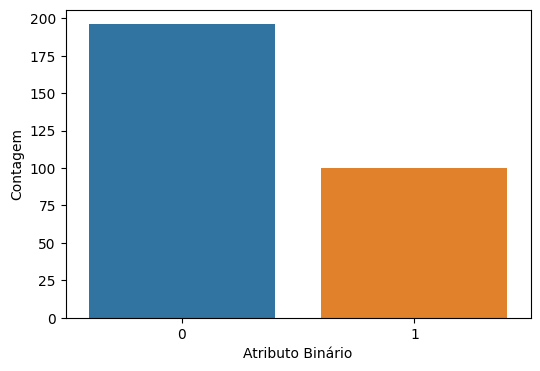

In [14]:
#Análise dos atributos binários
plt.figure(figsize=(6, 4))
sns.countplot(x="normality", data=df_clean)
plt.xlabel("Atributo Binário")
plt.ylabel("Contagem")
plt.show()

In [15]:
print(df_clean["normality"].value_counts())

0    196
1    100
Name: normality, dtype: int64


In [16]:
#Balanceando dados
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_clean, y_clean)
balanced_df = pd.concat([pd.DataFrame(x_resampled, columns=x_clean.columns), pd.Series(y_resampled, name="normality")], axis=1)
balanced_x = balanced_df.iloc[:, :-1]
balanced_y = balanced_df["normality"]
estimar_loss(balanced_x, balanced_y)
print(balanced_df["normality"].value_counts())

Loss do MLP Classifier: 0.23469823051296654
0    196
1    196
Name: normality, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


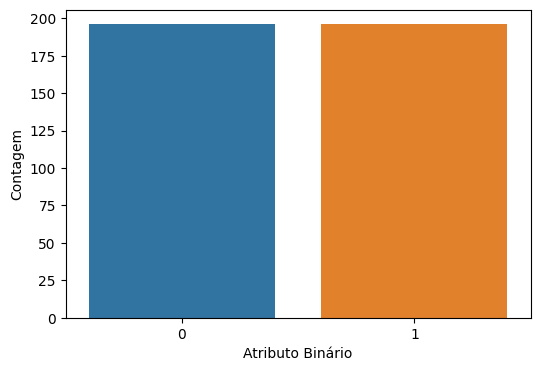

In [17]:
#Análise dos atributos binários
plt.figure(figsize=(6, 4))
sns.countplot(x="normality", data=balanced_df)
plt.xlabel("Atributo Binário")
plt.ylabel("Contagem")
plt.show()

###Normalização e Padronização

**Sumário Estatístico**

O resumo estatístico fornece estatísticas descritivas básicas para cada característica no df. Isso inclui a contagem de exemplos, média, desvio padrão, valor mínimo, quartis e valor máximo. Isso ajuda a ter uma visão geral das características e de suas escalas. Pode ser útil para identificar características com escalas muito diferentes e visualizar a necessidade de normalização.

In [18]:
#Sumário Estatístico
balanced_df.describe()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,normality
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,57.810532,15.906806,49.330108,41.903726,119.036809,17.666067,0.471132,21.543445,13.132572,11.935568,-14.073062,26.305530,0.500000
std,15.978789,8.756700,17.283902,11.835850,11.341660,25.107366,0.273188,8.480770,3.240146,2.832126,12.145607,10.347865,0.500639
min,26.147921,-6.554948,14.000000,13.366931,82.456038,-11.058179,0.003220,7.027000,7.037800,7.030600,-35.287375,7.007900,0.000000
25%,44.974529,9.836915,35.999550,33.215251,113.216491,0.790652,0.248929,13.418459,10.712725,9.617402,-24.640992,17.577375,0.000000
50%,54.935914,15.006480,46.048925,40.726254,119.401344,5.387938,0.479896,22.458750,13.106180,11.963525,-14.063307,26.342000,0.500000
75%,69.189420,20.445296,60.036160,50.283827,126.119788,31.388764,0.688529,28.907718,15.626396,14.259679,-3.933666,34.706236,1.000000
max,115.923261,42.689195,100.744220,78.794052,151.839857,110.860782,0.998827,36.743900,19.324000,16.821080,6.972071,44.341200,1.000000


**Distribuição de valores**

Os histogramas e os gráficos KDE mostram a distribuição dos valores em cada característica. Isso ajuda a entender a forma da distribuição, verificar se as características seguem uma distribuição normal e observar como os valores estão distribuídos. Isso pode influenciar a decisão de normalizar ou padronizar as características.

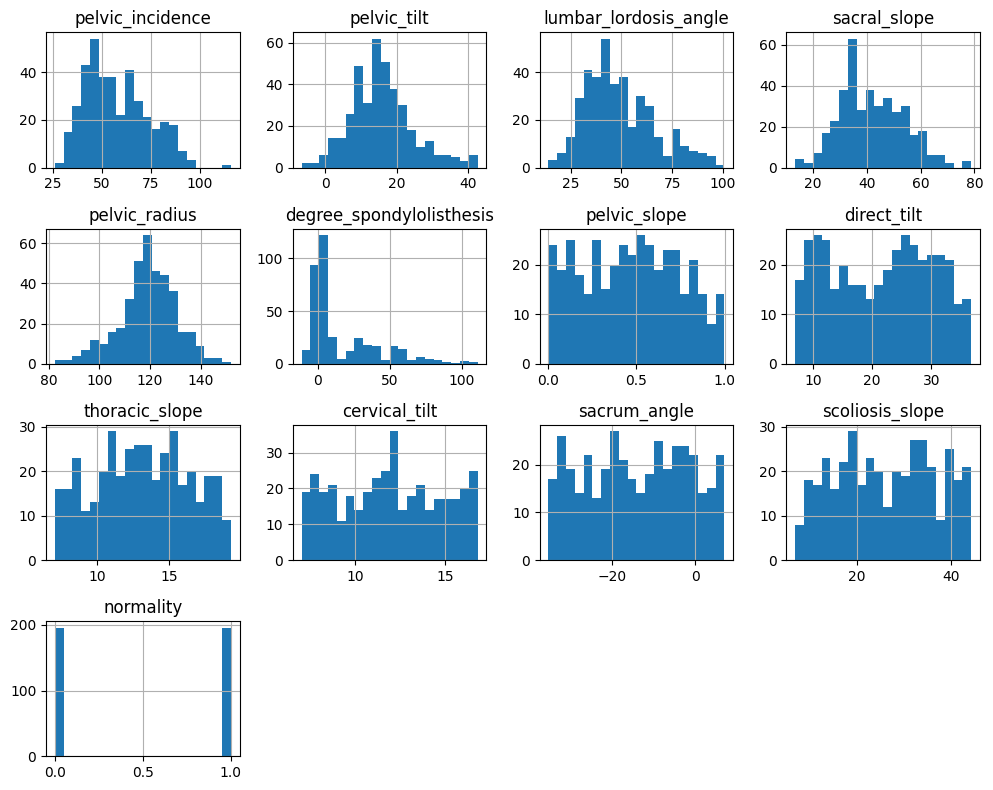

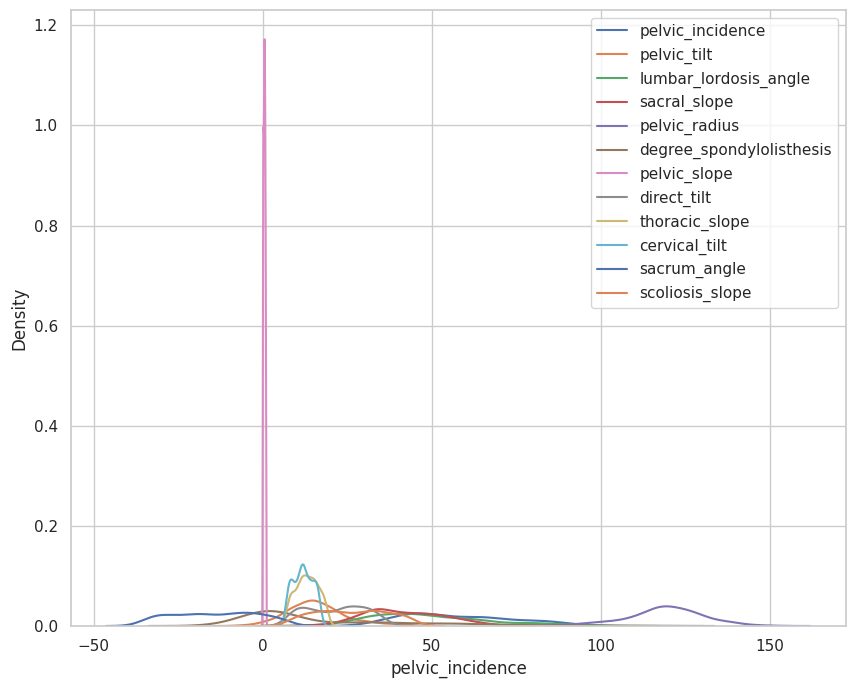

In [19]:
#Distribuição de valores
balanced_df.hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))
for col in x:
    sns.kdeplot(balanced_df[col], label=col)
plt.legend()
plt.show()

In [20]:
#Normalização
columns_to_normalize = ['pelvic_incidence','pelvic_tilt','lumbar_lordosis_angle','pelvic_radius'] #Distribuição semelhante a normal
scaler = MinMaxScaler()
normalized_df = balanced_df.copy()
normalized_df[columns_to_normalize] = scaler.fit_transform(balanced_df[columns_to_normalize])
normalized_x = normalized_df.iloc[:, :-1]
normalized_y = normalized_df["normality"]
estimar_loss(normalized_x, normalized_y)

Loss do MLP Classifier: 0.20813731852034187


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
#Padronização
columns_to_standardize = ['pelvic_tilt','sacral_slope','pelvic_radius','pelvic_slope','direct_tilt','thoracic_slope',
                          'cervical_tilt','sacrum_angle','scoliosis_slope'] #Desvio padrão pequeno
scaler = StandardScaler()
standardize_df = normalized_df.copy()
standardize_df[columns_to_standardize] = scaler.fit_transform(normalized_df[columns_to_standardize])
standardize_x = standardize_df.iloc[:, :-1]
standardize_y = standardize_df["normality"]
estimar_loss(standardize_x, standardize_y)

Loss do MLP Classifier: 0.15922471077707612


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


###Análise de Atributos

**Análise de Correlações**

A matriz de correlação e o mapa de calor ajudam a entender as relações lineares entre as características. Isso pode ser útil para identificar pares que estão altamente correlacionadas, o que pode indicar redundância. Em alguns casos, pode ser útil para a seleção de atributos, removendo características altamente correlacionadas.

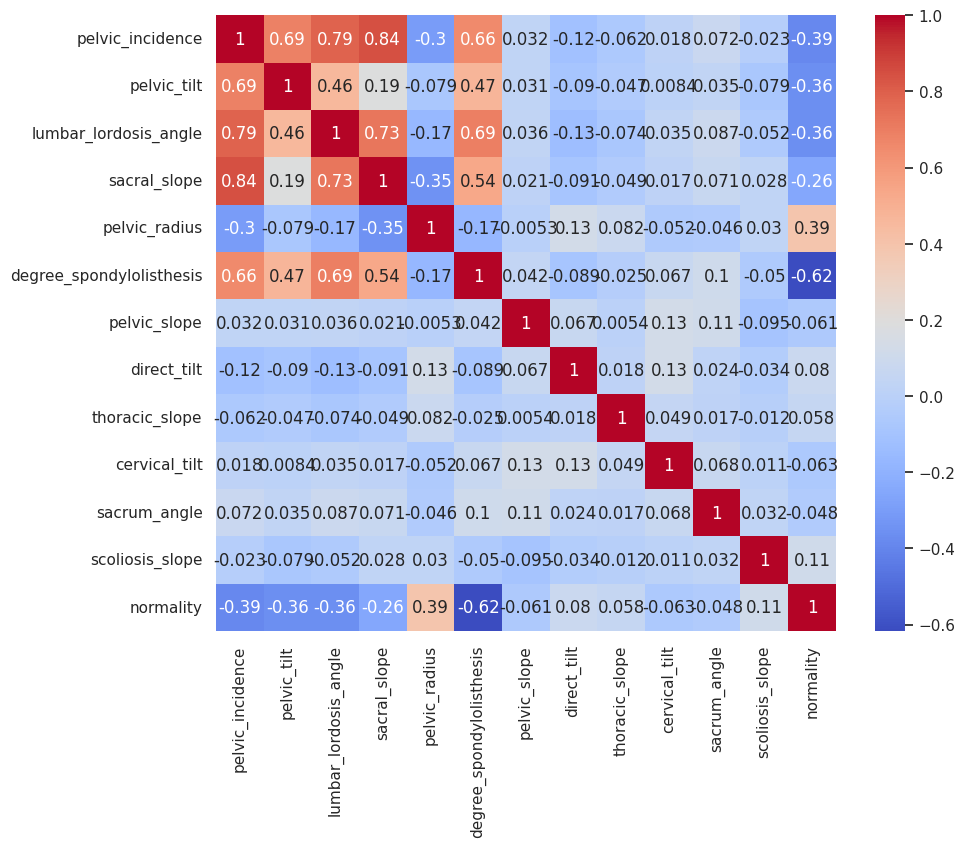

In [22]:
#Análise de Correlações
correlation_matrix = standardize_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.show()

In [23]:
correlation_matrix = standardize_df.corr()
df_filtered = standardize_df.copy()
corr_threshold = 0.8
#Caso nenhuma coluna tenha correlação de 80% ou mais, ficará o mesmo df
highly_correlated = (correlation_matrix.abs() > corr_threshold) & (correlation_matrix != 1)
features_to_remove = set()
for col in highly_correlated.columns:
    correlated_cols = highly_correlated.index[highly_correlated[col]].tolist()
    if len(correlated_cols) > 1:
      features_to_remove.add(correlated_cols[1])
df_filtered = df_filtered.drop(columns=features_to_remove)
x_filtered = df_filtered.iloc[:, :-1]
y_filtered = df_filtered["normality"]
estimar_loss(x_filtered,y_filtered)

Loss do MLP Classifier: 0.15922471077707612


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


##Treinamento e Teste (Valores Usuais)

In [24]:
#Divisão conjunto treino e test
x_train, x_test, y_train, y_test = train_test_split(x_filtered, y_filtered, test_size=0.15,random_state=42, shuffle=True)
print(f'x_train: {x_train.shape}')
print(f'x_test: {x_test.shape}')

x_train: (333, 12)
x_test: (59, 12)


In [25]:
# Criando MLP
losses = []
for i in range(10):
  mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5,
                               max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False,
                               warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False,
                               validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10,
                               max_fun=15000)

# Treinando com os parâmetros usuais
  mlp_classifier.fit(x_train, y_train)
  losses.append(mlp_classifier.loss_)
print("Loss do MLP Classifier:", np.mean(losses))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Loss do MLP Classifier: 0.15478382217131986


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Acurácia do modelo: 0.86
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.84      0.89        37
           1       0.77      0.91      0.83        22

    accuracy                           0.86        59
   macro avg       0.85      0.87      0.86        59
weighted avg       0.88      0.86      0.87        59



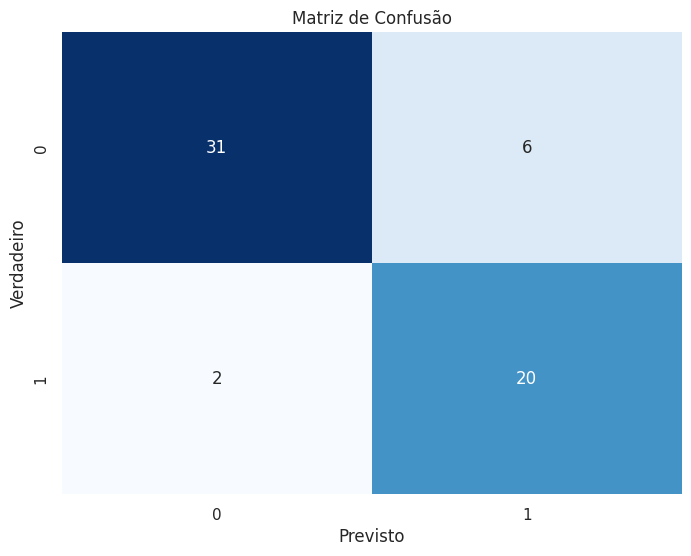

In [26]:
y_pred = mlp_classifier.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.2f}")
print("Classification Report")
print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

##Otimização de Hiperparâmetros

In [27]:
parameters = [Integer(1, 2, name='num_layers'),
              Integer(1, 128, name='nn_fst_layer'),
              Integer(1, 128, name='nn_snd_layer'),
              Categorical(['identity', 'logistic', 'tanh', 'relu'], name='activation'),
              Categorical(['adam', 'sgd', 'lbfgs'], name='solver'),
              Real(1e-6, 1e-2, prior='log-uniform', name='alpha'),
              Integer(1, 100, name='batch_size'),
              Categorical(['constant', 'invscaling', 'adaptive'], name='learning_rate'),
              Real(1e-6, 1e-3, prior='log-uniform', name='learning_rate_init'),
              Real(1e-6, 1e-1, prior='log-uniform', name='power_t'),
              Integer(500, 1000, name='max_iter'),
              Real(1e-6, 1e-2, prior='log-uniform', name='tol'),
              Real(0.1, 0.9, name='momentum'),
              Categorical([True, False], name='nesterovs_momentum'),
              Real(0.01, 0.5, name='validation_fraction'),
              Real(0.1, 0.9, name='beta_1'),
              Real(0.001, 0.999, name='beta_2'),
              Real(1e-10, 1e-6, prior='log-uniform', name='epsilon'),
              Integer(1, 100, name='n_iter_no_change'),
              Integer(1, 30000, name='max_fun')]

@use_named_args(parameters)
def objective(**params):
  print(params)
  split = ShuffleSplit(n_splits=2, test_size=0.15)
  indices = [train for  (train, test) in split.split(x_train.to_numpy())]
  data_x, data_y = (x_train.to_numpy())[indices[0]], (y_train.to_numpy())[indices[0]]
  split = ShuffleSplit(n_splits=5, test_size=0.2)
  accuracy = []
  for train, test in split.split(data_x):
    if(params["num_layers"] == 1):
        hidden_layer=(params["nn_fst_layer"],)
    if(params["num_layers"] == 2):
        hidden_layer=(params["nn_fst_layer"],params["nn_snd_layer"])

    mlp_classifier = MLPClassifier(hidden_layer_sizes=hidden_layer, activation=params['activation'], solver=params['solver'],
                                   alpha=params['alpha'],batch_size=params['batch_size'], learning_rate=params['learning_rate'],
                                   learning_rate_init=params['learning_rate_init'], power_t=params['power_t'],
                                   max_iter=params['max_iter'], shuffle=True, random_state=42,
                                   tol=params['tol'], verbose=False, warm_start=False, momentum=params['momentum'],
                                   nesterovs_momentum=params['nesterovs_momentum'], early_stopping=False,
                                   validation_fraction=params['validation_fraction'], beta_1=params['beta_1'],
                                   beta_2=params['beta_2'], epsilon=params['epsilon'], n_iter_no_change=params['n_iter_no_change'],
                                   max_fun=params['max_fun'])
    mlp_classifier.fit(data_x[train], data_y[train])
    y_pred = mlp_classifier.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_pred))
  return -np.array(accuracy).mean()

result = gbrt_minimize(func=objective, dimensions=parameters, n_calls=50, acq_func='EI', n_jobs=-1)

{'num_layers': 1, 'nn_fst_layer': 60, 'nn_snd_layer': 127, 'activation': 'tanh', 'solver': 'sgd', 'alpha': 5.88441544403621e-05, 'batch_size': 3, 'learning_rate': 'constant', 'learning_rate_init': 2.3067722041927477e-05, 'power_t': 0.007727532937138695, 'max_iter': 926, 'tol': 0.0018203456843217654, 'momentum': 0.7917144386827423, 'nesterovs_momentum': True, 'validation_fraction': 0.016898388706367423, 'beta_1': 0.4382634710461841, 'beta_2': 0.06501378256269795, 'epsilon': 2.5781183456902745e-09, 'n_iter_no_change': 23, 'max_fun': 3991}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 45, 'nn_snd_layer': 41, 'activation': 'identity', 'solver': 'sgd', 'alpha': 1.1877601209901353e-05, 'batch_size': 66, 'learning_rate': 'adaptive', 'learning_rate_init': 2.274140393662027e-06, 'power_t': 1.2340721299042642e-06, 'max_iter': 871, 'tol': 9.682887870516024e-05, 'momentum': 0.602537047454954, 'nesterovs_momentum': False, 'validation_fraction': 0.16639604829571056, 'beta_1': 0.2766409431010174, 'beta_2': 0.7972371040231178, 'epsilon': 6.018127261700969e-09, 'n_iter_no_change': 65, 'max_fun': 22614}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 83, 'nn_snd_layer': 32, 'activation': 'identity', 'solver': 'sgd', 'alpha': 4.139973970124217e-05, 'batch_size': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 3.795405772800814e-05, 'power_t': 2.9489839747915275e-06, 'max_iter': 918, 'tol': 2.3786948305967964e-06, 'momentum': 0.7900788287306341, 'nesterovs_momentum': False, 'validation_fraction': 0.4648489907041155, 'beta_1': 0.14698774812662319, 'beta_2': 0.7280174135394568, 'epsilon': 1.0017907145630264e-09, 'n_iter_no_change': 98, 'max_fun': 15688}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (918) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (918) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (918) reached and the optimization hasn't converged yet.
  wa

{'num_layers': 1, 'nn_fst_layer': 51, 'nn_snd_layer': 117, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 1.6361959240789964e-05, 'batch_size': 46, 'learning_rate': 'invscaling', 'learning_rate_init': 0.00045626619439419105, 'power_t': 0.001078172135901557, 'max_iter': 737, 'tol': 7.709989289908189e-06, 'momentum': 0.8897320239481403, 'nesterovs_momentum': False, 'validation_fraction': 0.4103011189679322, 'beta_1': 0.7796605678351395, 'beta_2': 0.5609382993039985, 'epsilon': 2.0671107882795304e-09, 'n_iter_no_change': 4, 'max_fun': 16581}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 22, 'nn_snd_layer': 75, 'activation': 'relu', 'solver': 'sgd', 'alpha': 4.241119948250281e-05, 'batch_size': 85, 'learning_rate': 'adaptive', 'learning_rate_init': 5.3379963059751865e-06, 'power_t': 0.0015489219462588176, 'max_iter': 904, 'tol': 0.00332957309130042, 'momentum': 0.7619300518448314, 'nesterovs_momentum': True, 'validation_fraction': 0.07704546084379214, 'beta_1': 0.3079211004078749, 'beta_2': 0.5960404962321362, 'epsilon': 1.3264038723795048e-08, 'n_iter_no_change': 23, 'max_fun': 1873}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 89, 'nn_snd_layer': 2, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0008697479925676794, 'batch_size': 47, 'learning_rate': 'invscaling', 'learning_rate_init': 9.430051157920702e-05, 'power_t': 0.013135679757409358, 'max_iter': 821, 'tol': 0.0004987627123289927, 'momentum': 0.77022837742721, 'nesterovs_momentum': True, 'validation_fraction': 0.13089400474257853, 'beta_1': 0.380233449752312, 'beta_2': 0.3362030111887359, 'epsilon': 9.937103537980937e-09, 'n_iter_no_change': 27, 'max_fun': 1838}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 46, 'nn_snd_layer': 103, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 5.498027286508785e-05, 'batch_size': 5, 'learning_rate': 'adaptive', 'learning_rate_init': 1.6883663334536355e-05, 'power_t': 0.03175213241811415, 'max_iter': 806, 'tol': 0.00036123269883329203, 'momentum': 0.2278280821922594, 'nesterovs_momentum': True, 'validation_fraction': 0.45049621212871216, 'beta_1': 0.8889545194687201, 'beta_2': 0.4915745011681681, 'epsilon': 6.357449413067958e-10, 'n_iter_no_change': 88, 'max_fun': 20840}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 116, 'nn_snd_layer': 76, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 1.0519335361472198e-05, 'batch_size': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 1.1391938503343714e-05, 'power_t': 0.00025900123451145146, 'max_iter': 722, 'tol': 1.420404835782932e-06, 'momentum': 0.1204350167925215, 'nesterovs_momentum': True, 'validation_fraction': 0.3183702392633542, 'beta_1': 0.29667217801313794, 'beta_2': 0.5336367255136976, 'epsilon': 9.472053166883784e-07, 'n_iter_no_change': 79, 'max_fun': 21149}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 1, 'nn_snd_layer': 49, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.0021986578352676343, 'batch_size': 29, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005638915826335362, 'power_t': 7.599843090484911e-06, 'max_iter': 558, 'tol': 0.00025565826955850667, 'momentum': 0.7299700543551247, 'nesterovs_momentum': False, 'validation_fraction': 0.19676386869551937, 'beta_1': 0.7267982327875118, 'beta_2': 0.6139781064049253, 'epsilon': 1.6298015487181577e-09, 'n_iter_no_change': 48, 'max_fun': 15614}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLP

{'num_layers': 1, 'nn_fst_layer': 10, 'nn_snd_layer': 68, 'activation': 'tanh', 'solver': 'adam', 'alpha': 2.1423110212607217e-06, 'batch_size': 76, 'learning_rate': 'invscaling', 'learning_rate_init': 7.085499671362183e-06, 'power_t': 4.473275926910136e-06, 'max_iter': 802, 'tol': 1.1901739046132499e-05, 'momentum': 0.7892074215503307, 'nesterovs_momentum': True, 'validation_fraction': 0.284839368346265, 'beta_1': 0.10843120727651057, 'beta_2': 0.13990247407711354, 'epsilon': 9.482333510271225e-10, 'n_iter_no_change': 61, 'max_fun': 16715}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (802) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (802) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (802) reached and the optimization hasn't converged yet.
  wa

{'num_layers': 2, 'nn_fst_layer': 101, 'nn_snd_layer': 10, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 1.3379953010677393e-05, 'batch_size': 25, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0003498985410027283, 'power_t': 2.802592233694136e-06, 'max_iter': 535, 'tol': 4.070222354543135e-06, 'momentum': 0.3695986645243565, 'nesterovs_momentum': False, 'validation_fraction': 0.39384484150442783, 'beta_1': 0.6632818034324466, 'beta_2': 0.6759666900791373, 'epsilon': 9.627757172603179e-08, 'n_iter_no_change': 49, 'max_fun': 1355}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/pyth

{'num_layers': 2, 'nn_fst_layer': 115, 'nn_snd_layer': 4, 'activation': 'logistic', 'solver': 'adam', 'alpha': 2.1616288010444874e-05, 'batch_size': 33, 'learning_rate': 'adaptive', 'learning_rate_init': 1.7986883675958322e-05, 'power_t': 0.053831916980443775, 'max_iter': 676, 'tol': 2.3596644227265403e-06, 'momentum': 0.7050435659243472, 'nesterovs_momentum': False, 'validation_fraction': 0.48033661782577086, 'beta_1': 0.13662834741667487, 'beta_2': 0.1613693482873648, 'epsilon': 7.170585661359014e-08, 'n_iter_no_change': 2, 'max_fun': 20412}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (676) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (676) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (676) reached and the optimization hasn't converged yet.
  wa

{'num_layers': 1, 'nn_fst_layer': 18, 'nn_snd_layer': 19, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 2.112050295767597e-06, 'batch_size': 15, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0004148327807961496, 'power_t': 7.849278435393835e-06, 'max_iter': 788, 'tol': 1.1327888900745185e-06, 'momentum': 0.8818170220952737, 'nesterovs_momentum': False, 'validation_fraction': 0.0614671119693977, 'beta_1': 0.3603829041591122, 'beta_2': 0.18071505493236537, 'epsilon': 4.271569514093914e-08, 'n_iter_no_change': 21, 'max_fun': 27195}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 86, 'nn_snd_layer': 32, 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 5.749255424138611e-05, 'batch_size': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000492188722966709, 'power_t': 2.512421531670059e-06, 'max_iter': 650, 'tol': 2.85238974749995e-06, 'momentum': 0.886510134074865, 'nesterovs_momentum': True, 'validation_fraction': 0.18309366365893817, 'beta_1': 0.5621079557586488, 'beta_2': 0.9972134882195675, 'epsilon': 1.466086479385698e-08, 'n_iter_no_change': 87, 'max_fun': 22071}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 121, 'nn_snd_layer': 61, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 1.1286970678831525e-06, 'batch_size': 61, 'learning_rate': 'constant', 'learning_rate_init': 0.00035314530732334323, 'power_t': 0.07015018554385961, 'max_iter': 513, 'tol': 3.6470766734888923e-06, 'momentum': 0.896892387083247, 'nesterovs_momentum': True, 'validation_fraction': 0.050540201158859856, 'beta_1': 0.3135295159676842, 'beta_2': 0.6826145157151667, 'epsilon': 9.550905840330139e-09, 'n_iter_no_change': 17, 'max_fun': 24333}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 34, 'nn_snd_layer': 2, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 3.405898228107482e-05, 'batch_size': 35, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0005172017823446524, 'power_t': 0.00016576302385372762, 'max_iter': 645, 'tol': 0.005742639713051132, 'momentum': 0.2067213717746608, 'nesterovs_momentum': False, 'validation_fraction': 0.06289361667981307, 'beta_1': 0.20314606228476778, 'beta_2': 0.6001142678523886, 'epsilon': 1.345047922855992e-08, 'n_iter_no_change': 80, 'max_fun': 28734}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 18, 'nn_snd_layer': 108, 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 1.2060404831452679e-05, 'batch_size': 23, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00047894930050769235, 'power_t': 0.000785669274573418, 'max_iter': 527, 'tol': 0.0012582038401450872, 'momentum': 0.2804046880026875, 'nesterovs_momentum': True, 'validation_fraction': 0.4621679438966972, 'beta_1': 0.8848176348392771, 'beta_2': 0.5046519155689181, 'epsilon': 4.116046150993685e-08, 'n_iter_no_change': 66, 'max_fun': 15696}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 21, 'nn_snd_layer': 68, 'activation': 'identity', 'solver': 'adam', 'alpha': 0.009674485960232402, 'batch_size': 86, 'learning_rate': 'invscaling', 'learning_rate_init': 0.00013908932641794778, 'power_t': 1.17926048739687e-05, 'max_iter': 703, 'tol': 4.210457872565849e-05, 'momentum': 0.8244025359759314, 'nesterovs_momentum': True, 'validation_fraction': 0.14705565225768896, 'beta_1': 0.5265188131909713, 'beta_2': 0.5021912661952145, 'epsilon': 2.395913240317723e-09, 'n_iter_no_change': 98, 'max_fun': 18563}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (703) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (703) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (703) reached and the optimization hasn't converged yet.
  wa

{'num_layers': 1, 'nn_fst_layer': 51, 'nn_snd_layer': 29, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.00011910927105308944, 'batch_size': 11, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00034691717516875545, 'power_t': 1.033481728535233e-06, 'max_iter': 876, 'tol': 0.0002692065314271982, 'momentum': 0.4011657396095305, 'nesterovs_momentum': False, 'validation_fraction': 0.4778576104382654, 'beta_1': 0.8208297649772928, 'beta_2': 0.3446075407302217, 'epsilon': 2.7822211508285247e-09, 'n_iter_no_change': 4, 'max_fun': 14300}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 96, 'nn_snd_layer': 10, 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 4.740844903282307e-06, 'batch_size': 55, 'learning_rate': 'adaptive', 'learning_rate_init': 3.252762078115642e-05, 'power_t': 6.061736710510986e-05, 'max_iter': 872, 'tol': 0.007062542023018805, 'momentum': 0.584086512527769, 'nesterovs_momentum': False, 'validation_fraction': 0.4722275243812396, 'beta_1': 0.8926904432251009, 'beta_2': 0.747375529612447, 'epsilon': 1.4212142223051518e-10, 'n_iter_no_change': 22, 'max_fun': 29651}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 22, 'nn_snd_layer': 54, 'activation': 'relu', 'solver': 'adam', 'alpha': 2.594243857195582e-05, 'batch_size': 94, 'learning_rate': 'constant', 'learning_rate_init': 0.0004731448484768677, 'power_t': 3.0146691701791363e-05, 'max_iter': 627, 'tol': 3.3475464703980707e-06, 'momentum': 0.329275821606849, 'nesterovs_momentum': True, 'validation_fraction': 0.2928875319401799, 'beta_1': 0.41530707110142095, 'beta_2': 0.45871292798241287, 'epsilon': 8.449893997402094e-09, 'n_iter_no_change': 70, 'max_fun': 29816}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (627) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (627) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (627) reached and the optimization hasn't converged yet.
  wa

{'num_layers': 2, 'nn_fst_layer': 42, 'nn_snd_layer': 71, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.0016797304312511862, 'batch_size': 52, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0005208012653703742, 'power_t': 1.3499894600491117e-06, 'max_iter': 801, 'tol': 2.437733590381186e-06, 'momentum': 0.805771513687481, 'nesterovs_momentum': False, 'validation_fraction': 0.4688985210894677, 'beta_1': 0.2334915810999844, 'beta_2': 0.9522742442962157, 'epsilon': 3.351998611086149e-07, 'n_iter_no_change': 53, 'max_fun': 23205}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/pyth

{'num_layers': 1, 'nn_fst_layer': 113, 'nn_snd_layer': 62, 'activation': 'relu', 'solver': 'sgd', 'alpha': 0.006894372314805862, 'batch_size': 73, 'learning_rate': 'constant', 'learning_rate_init': 0.0008464565005359459, 'power_t': 0.0006972411333659098, 'max_iter': 816, 'tol': 2.569687153610582e-06, 'momentum': 0.5118761911444966, 'nesterovs_momentum': True, 'validation_fraction': 0.46221218086219124, 'beta_1': 0.8178373757038014, 'beta_2': 0.38963959670224735, 'epsilon': 2.149796704389698e-08, 'n_iter_no_change': 74, 'max_fun': 17205}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (816) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (816) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (816) reached and the optimization hasn't converged yet.
  wa

{'num_layers': 1, 'nn_fst_layer': 14, 'nn_snd_layer': 119, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.000308136459092429, 'batch_size': 57, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0005028745462816259, 'power_t': 0.01089259122905439, 'max_iter': 555, 'tol': 0.008413326971707265, 'momentum': 0.6477572199130901, 'nesterovs_momentum': False, 'validation_fraction': 0.1684744758903124, 'beta_1': 0.49234940338375144, 'beta_2': 0.24665291562112376, 'epsilon': 6.966449674834443e-10, 'n_iter_no_change': 46, 'max_fun': 22800}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 16, 'nn_snd_layer': 128, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.00012982676200121193, 'batch_size': 74, 'learning_rate': 'adaptive', 'learning_rate_init': 7.442856566988715e-05, 'power_t': 0.0007675632758251248, 'max_iter': 715, 'tol': 0.00013397093968413974, 'momentum': 0.8729463886523248, 'nesterovs_momentum': True, 'validation_fraction': 0.2911679508714933, 'beta_1': 0.2902653024442371, 'beta_2': 0.24387252966704778, 'epsilon': 8.445173603488189e-10, 'n_iter_no_change': 95, 'max_fun': 939}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 34, 'nn_snd_layer': 107, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00010798039710608108, 'batch_size': 5, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007294646442744826, 'power_t': 0.02493782004753923, 'max_iter': 1000, 'tol': 1.1866092701728781e-06, 'momentum': 0.8490665790658918, 'nesterovs_momentum': True, 'validation_fraction': 0.24065670002224648, 'beta_1': 0.3597433085209999, 'beta_2': 0.7448218843242942, 'epsilon': 2.0780621985513346e-09, 'n_iter_no_change': 4, 'max_fun': 24581}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 26, 'nn_snd_layer': 7, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 0.000475143786324968, 'batch_size': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 8.229590554300628e-06, 'power_t': 0.00072171947421128, 'max_iter': 681, 'tol': 1.1473614023347014e-06, 'momentum': 0.8700972846925952, 'nesterovs_momentum': False, 'validation_fraction': 0.16536690365896078, 'beta_1': 0.15058899930599196, 'beta_2': 0.061028950331565794, 'epsilon': 1.4957411233533675e-08, 'n_iter_no_change': 86, 'max_fun': 4346}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (681) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (681) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (681) reached and the optimization hasn't converged yet.
  wa

{'num_layers': 1, 'nn_fst_layer': 30, 'nn_snd_layer': 49, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.0001668612518240782, 'batch_size': 57, 'learning_rate': 'constant', 'learning_rate_init': 0.0001687235340116945, 'power_t': 0.00038788259038240755, 'max_iter': 921, 'tol': 3.6657544270745957e-06, 'momentum': 0.34418256406549197, 'nesterovs_momentum': False, 'validation_fraction': 0.1792853066681872, 'beta_1': 0.5815105524089883, 'beta_2': 0.05281534169268936, 'epsilon': 1.2783618786023877e-07, 'n_iter_no_change': 35, 'max_fun': 7127}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 47, 'nn_snd_layer': 1, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 3.084674812171382e-05, 'batch_size': 95, 'learning_rate': 'invscaling', 'learning_rate_init': 1.0990419033612767e-05, 'power_t': 0.0003013836579687606, 'max_iter': 990, 'tol': 1.0192918404843294e-06, 'momentum': 0.8553560659661043, 'nesterovs_momentum': True, 'validation_fraction': 0.10948147601121767, 'beta_1': 0.7837449632808742, 'beta_2': 0.4774156288954914, 'epsilon': 3.3899316600740993e-09, 'n_iter_no_change': 89, 'max_fun': 4208}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 107, 'nn_snd_layer': 3, 'activation': 'identity', 'solver': 'sgd', 'alpha': 0.0009658830272040186, 'batch_size': 40, 'learning_rate': 'adaptive', 'learning_rate_init': 3.998793580319288e-05, 'power_t': 0.0009623989363446846, 'max_iter': 702, 'tol': 0.00012716460235978863, 'momentum': 0.527081614004831, 'nesterovs_momentum': False, 'validation_fraction': 0.38670834477895466, 'beta_1': 0.1356132356834052, 'beta_2': 0.03502020855760833, 'epsilon': 4.886967410053296e-07, 'n_iter_no_change': 54, 'max_fun': 23880}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (702) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (702) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neura

{'num_layers': 2, 'nn_fst_layer': 7, 'nn_snd_layer': 97, 'activation': 'logistic', 'solver': 'adam', 'alpha': 1.3872334990713376e-05, 'batch_size': 36, 'learning_rate': 'constant', 'learning_rate_init': 0.00046444932031718453, 'power_t': 1.4152801458853821e-05, 'max_iter': 563, 'tol': 9.779188387762357e-06, 'momentum': 0.7913097143927444, 'nesterovs_momentum': True, 'validation_fraction': 0.32772520754250345, 'beta_1': 0.7733133010335694, 'beta_2': 0.013007929339598986, 'epsilon': 1.0594344940491364e-09, 'n_iter_no_change': 19, 'max_fun': 26202}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (563) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (563) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.

{'num_layers': 2, 'nn_fst_layer': 116, 'nn_snd_layer': 1, 'activation': 'logistic', 'solver': 'adam', 'alpha': 0.0004141801203893608, 'batch_size': 74, 'learning_rate': 'constant', 'learning_rate_init': 0.00016554914938680316, 'power_t': 0.00019857513491019547, 'max_iter': 794, 'tol': 1.084887051471218e-06, 'momentum': 0.8238782925766223, 'nesterovs_momentum': True, 'validation_fraction': 0.3903922356204036, 'beta_1': 0.7194510556777169, 'beta_2': 0.6267622664385594, 'epsilon': 2.8916227502704014e-08, 'n_iter_no_change': 30, 'max_fun': 4673}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (794) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (794) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (794) reached and the optimization hasn't converged yet.
  wa

{'num_layers': 2, 'nn_fst_layer': 104, 'nn_snd_layer': 94, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.0017099349733236445, 'batch_size': 99, 'learning_rate': 'invscaling', 'learning_rate_init': 3.1054181906728564e-06, 'power_t': 1.5658118886966435e-05, 'max_iter': 613, 'tol': 1.591055316095649e-06, 'momentum': 0.21585562382330076, 'nesterovs_momentum': False, 'validation_fraction': 0.2424295192721184, 'beta_1': 0.10690438365046379, 'beta_2': 0.44446052974837263, 'epsilon': 1.265868356133057e-08, 'n_iter_no_change': 74, 'max_fun': 513}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (613) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (613) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (613) reached and the optimization hasn't converged yet.
  wa

{'num_layers': 2, 'nn_fst_layer': 48, 'nn_snd_layer': 51, 'activation': 'identity', 'solver': 'sgd', 'alpha': 9.36998515382639e-06, 'batch_size': 65, 'learning_rate': 'constant', 'learning_rate_init': 0.0006200093960852048, 'power_t': 0.0036809770744178345, 'max_iter': 610, 'tol': 1.050390949857825e-06, 'momentum': 0.3852898639214104, 'nesterovs_momentum': False, 'validation_fraction': 0.4474348785163896, 'beta_1': 0.3701868039772547, 'beta_2': 0.06400638072189371, 'epsilon': 6.155855445396255e-10, 'n_iter_no_change': 60, 'max_fun': 25394}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (610) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (610) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (610) reached and the optimization hasn't converged yet.
  wa

{'num_layers': 1, 'nn_fst_layer': 89, 'nn_snd_layer': 3, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0006895801766643896, 'batch_size': 40, 'learning_rate': 'invscaling', 'learning_rate_init': 6.2445968394405465e-06, 'power_t': 0.001971297258730687, 'max_iter': 903, 'tol': 3.29905163806113e-05, 'momentum': 0.3758438040292338, 'nesterovs_momentum': True, 'validation_fraction': 0.18979890235100733, 'beta_1': 0.20203970988550649, 'beta_2': 0.009238542893497147, 'epsilon': 1.1036028383920912e-09, 'n_iter_no_change': 67, 'max_fun': 1245}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 15, 'nn_snd_layer': 7, 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 1.0224547404268236e-05, 'batch_size': 93, 'learning_rate': 'invscaling', 'learning_rate_init': 1.515761420949963e-06, 'power_t': 2.9807748466048407e-05, 'max_iter': 904, 'tol': 7.006076218023047e-06, 'momentum': 0.8945319621795963, 'nesterovs_momentum': False, 'validation_fraction': 0.3954219210455589, 'beta_1': 0.4532791281479198, 'beta_2': 0.9273728858607656, 'epsilon': 3.3509276190784446e-09, 'n_iter_no_change': 19, 'max_fun': 14881}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 37, 'nn_snd_layer': 18, 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 0.0022079823443064413, 'batch_size': 21, 'learning_rate': 'adaptive', 'learning_rate_init': 7.736380174350102e-06, 'power_t': 0.00010783547698178213, 'max_iter': 953, 'tol': 1.1443236075180356e-06, 'momentum': 0.39367692943721677, 'nesterovs_momentum': False, 'validation_fraction': 0.4852152290347929, 'beta_1': 0.4827282183799628, 'beta_2': 0.43371179218809625, 'epsilon': 3.7814155401423247e-10, 'n_iter_no_change': 8, 'max_fun': 5874}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 24, 'nn_snd_layer': 128, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.004034870147212609, 'batch_size': 91, 'learning_rate': 'invscaling', 'learning_rate_init': 6.135122279364826e-06, 'power_t': 0.0007315029466703644, 'max_iter': 979, 'tol': 4.599987674898544e-05, 'momentum': 0.4106955877308577, 'nesterovs_momentum': True, 'validation_fraction': 0.12454833787123099, 'beta_1': 0.17024386540944203, 'beta_2': 0.6785510229527744, 'epsilon': 3.105073072601127e-10, 'n_iter_no_change': 100, 'max_fun': 24977}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 18, 'nn_snd_layer': 123, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0039214259481806695, 'batch_size': 47, 'learning_rate': 'invscaling', 'learning_rate_init': 9.774909771719096e-05, 'power_t': 0.010628339028371311, 'max_iter': 557, 'tol': 1.7285159394162326e-06, 'momentum': 0.5447073759450191, 'nesterovs_momentum': False, 'validation_fraction': 0.07407387975407902, 'beta_1': 0.12718912084129652, 'beta_2': 0.47886259865985237, 'epsilon': 1.044795763592367e-09, 'n_iter_no_change': 5, 'max_fun': 2991}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: Converge

{'num_layers': 1, 'nn_fst_layer': 58, 'nn_snd_layer': 6, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.008097058126103977, 'batch_size': 99, 'learning_rate': 'adaptive', 'learning_rate_init': 2.6285178013273782e-06, 'power_t': 6.291164358915712e-06, 'max_iter': 620, 'tol': 4.3351319837638245e-05, 'momentum': 0.8299321182382878, 'nesterovs_momentum': False, 'validation_fraction': 0.11497723953627345, 'beta_1': 0.3184117785718311, 'beta_2': 0.05468202427260927, 'epsilon': 2.1601562776693364e-09, 'n_iter_no_change': 86, 'max_fun': 25914}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 41, 'nn_snd_layer': 90, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.0044096333800824495, 'batch_size': 99, 'learning_rate': 'adaptive', 'learning_rate_init': 5.379003292906596e-06, 'power_t': 3.2410609469010383e-06, 'max_iter': 509, 'tol': 1.017304486869379e-06, 'momentum': 0.3187248868725959, 'nesterovs_momentum': True, 'validation_fraction': 0.4473148169648237, 'beta_1': 0.12177818002046524, 'beta_2': 0.09745834287992643, 'epsilon': 4.836939060008291e-08, 'n_iter_no_change': 58, 'max_fun': 14906}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/pyth

{'num_layers': 2, 'nn_fst_layer': 10, 'nn_snd_layer': 30, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.000996742104221921, 'batch_size': 15, 'learning_rate': 'invscaling', 'learning_rate_init': 0.00023336629070836956, 'power_t': 0.07507807236904018, 'max_iter': 505, 'tol': 0.0013270222132387927, 'momentum': 0.8500984888213448, 'nesterovs_momentum': False, 'validation_fraction': 0.257325629516244, 'beta_1': 0.6173873090778284, 'beta_2': 0.6773136512003485, 'epsilon': 1.3724146802368132e-08, 'n_iter_no_change': 78, 'max_fun': 4485}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 33, 'nn_snd_layer': 89, 'activation': 'logistic', 'solver': 'adam', 'alpha': 7.458019564994481e-06, 'batch_size': 19, 'learning_rate': 'adaptive', 'learning_rate_init': 9.89965839132273e-06, 'power_t': 0.0004304916761111288, 'max_iter': 707, 'tol': 0.0001247664806898043, 'momentum': 0.23159228280166036, 'nesterovs_momentum': True, 'validation_fraction': 0.49768121607621457, 'beta_1': 0.35357735173497806, 'beta_2': 0.6794967817866192, 'epsilon': 1.4309567952580232e-09, 'n_iter_no_change': 97, 'max_fun': 4291}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (707) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (707) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (707) reached and the optimization hasn't converged yet.
  wa

{'num_layers': 2, 'nn_fst_layer': 16, 'nn_snd_layer': 13, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 5.545763146862674e-05, 'batch_size': 68, 'learning_rate': 'invscaling', 'learning_rate_init': 3.676970302090313e-06, 'power_t': 1.1607495138902334e-06, 'max_iter': 725, 'tol': 0.00014472418699322645, 'momentum': 0.8874147458482402, 'nesterovs_momentum': True, 'validation_fraction': 0.07926162074089388, 'beta_1': 0.8934548534306599, 'beta_2': 0.05810741964506274, 'epsilon': 2.308357931036799e-07, 'n_iter_no_change': 51, 'max_fun': 5460}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 19, 'nn_snd_layer': 7, 'activation': 'tanh', 'solver': 'lbfgs', 'alpha': 0.0005765194522123815, 'batch_size': 72, 'learning_rate': 'constant', 'learning_rate_init': 0.0005014413388997113, 'power_t': 7.263870919452462e-05, 'max_iter': 789, 'tol': 0.00022244885163883788, 'momentum': 0.8915680892494638, 'nesterovs_momentum': False, 'validation_fraction': 0.4879105001197272, 'beta_1': 0.4549257027731678, 'beta_2': 0.12941387810821495, 'epsilon': 1.7448048133662824e-09, 'n_iter_no_change': 80, 'max_fun': 1507}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 1, 'nn_fst_layer': 2, 'nn_snd_layer': 2, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 0.00292840177543063, 'batch_size': 43, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005254007670062652, 'power_t': 0.001136995280119362, 'max_iter': 890, 'tol': 3.1149483418581985e-06, 'momentum': 0.5995182396372464, 'nesterovs_momentum': True, 'validation_fraction': 0.31821502547120073, 'beta_1': 0.7132455388480792, 'beta_2': 0.6772308328005707, 'epsilon': 3.918791111150137e-08, 'n_iter_no_change': 28, 'max_fun': 2090}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 11, 'nn_snd_layer': 8, 'activation': 'relu', 'solver': 'lbfgs', 'alpha': 5.635853984553504e-05, 'batch_size': 95, 'learning_rate': 'invscaling', 'learning_rate_init': 0.00010112860973671964, 'power_t': 2.0966771013803213e-05, 'max_iter': 878, 'tol': 0.00025330502576307245, 'momentum': 0.6121871867174342, 'nesterovs_momentum': False, 'validation_fraction': 0.14689692171979446, 'beta_1': 0.4615332012395533, 'beta_2': 0.8195181502892838, 'epsilon': 7.925421173954463e-07, 'n_iter_no_change': 79, 'max_fun': 1648}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 80, 'nn_snd_layer': 1, 'activation': 'logistic', 'solver': 'lbfgs', 'alpha': 0.0045231688267480166, 'batch_size': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 2.791755863359452e-05, 'power_t': 0.029242241926283965, 'max_iter': 574, 'tol': 2.0997494624682364e-05, 'momentum': 0.7407440234932069, 'nesterovs_momentum': True, 'validation_fraction': 0.043571738715074027, 'beta_1': 0.592182249474592, 'beta_2': 0.9951146763395033, 'epsilon': 2.383400439977357e-07, 'n_iter_no_change': 99, 'max_fun': 25545}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/pyth

{'num_layers': 1, 'nn_fst_layer': 10, 'nn_snd_layer': 4, 'activation': 'relu', 'solver': 'sgd', 'alpha': 1.291642687640286e-06, 'batch_size': 95, 'learning_rate': 'adaptive', 'learning_rate_init': 2.5200088484573617e-06, 'power_t': 0.00038774604727514507, 'max_iter': 824, 'tol': 7.605543637878938e-05, 'momentum': 0.5424444498263884, 'nesterovs_momentum': False, 'validation_fraction': 0.46733716357885113, 'beta_1': 0.8274314541693221, 'beta_2': 0.4309808020990742, 'epsilon': 2.1533349803221686e-10, 'n_iter_no_change': 32, 'max_fun': 24786}


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


{'num_layers': 2, 'nn_fst_layer': 79, 'nn_snd_layer': 27, 'activation': 'logistic', 'solver': 'sgd', 'alpha': 4.267421685158142e-06, 'batch_size': 62, 'learning_rate': 'constant', 'learning_rate_init': 0.000867169063266772, 'power_t': 0.028816661479236328, 'max_iter': 859, 'tol': 1.046539494914129e-06, 'momentum': 0.44912553871441674, 'nesterovs_momentum': True, 'validation_fraction': 0.1635104953781038, 'beta_1': 0.870695819866112, 'beta_2': 0.4454586298471939, 'epsilon': 3.708823740587275e-08, 'n_iter_no_change': 74, 'max_fun': 4374}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (859) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (859) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (859) reached and the optimization hasn't converged yet.
  wa

In [28]:
result.x

[2,
 42,
 71,
 'logistic',
 'lbfgs',
 0.0016797304312511862,
 52,
 'invscaling',
 0.0005208012653703742,
 1.3499894600491117e-06,
 801,
 2.437733590381186e-06,
 0.805771513687481,
 False,
 0.4688985210894677,
 0.2334915810999844,
 0.9522742442962157,
 3.351998611086149e-07,
 53,
 23205]

In [29]:
if(result.x[0] == 1):
  hidden_layer=(result.x[1],)
if(result.x[0] == 2):
  hidden_layer=(result.x[1],result.x[2])

losses = []
for i in range(10):
  mlp_classifier = MLPClassifier(hidden_layer_sizes=hidden_layer, activation=result.x[3], solver=result.x[4], alpha=result.x[5],
                               batch_size=result.x[6], learning_rate=result.x[7], learning_rate_init=result.x[8], power_t=result.x[9],
                               max_iter=result.x[10], shuffle=True, random_state=None, tol=result.x[11], verbose=False,
                               warm_start=False, momentum=result.x[12], nesterovs_momentum=result.x[13], early_stopping=False,
                               validation_fraction=result.x[14], beta_1=result.x[15], beta_2=result.x[16], epsilon=result.x[17],
                               n_iter_no_change=result.x[18], max_fun=result.x[19])

  mlp_classifier.fit(x_train, y_train)
  losses.append(mlp_classifier.loss_)
print("Loss do MLP Classifier:", np.mean(losses))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

Loss do MLP Classifier: 0.0013173242808889325


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Acurácia do modelo: 0.90
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        37
           1       0.83      0.91      0.87        22

    accuracy                           0.90        59
   macro avg       0.89      0.90      0.89        59
weighted avg       0.90      0.90      0.90        59



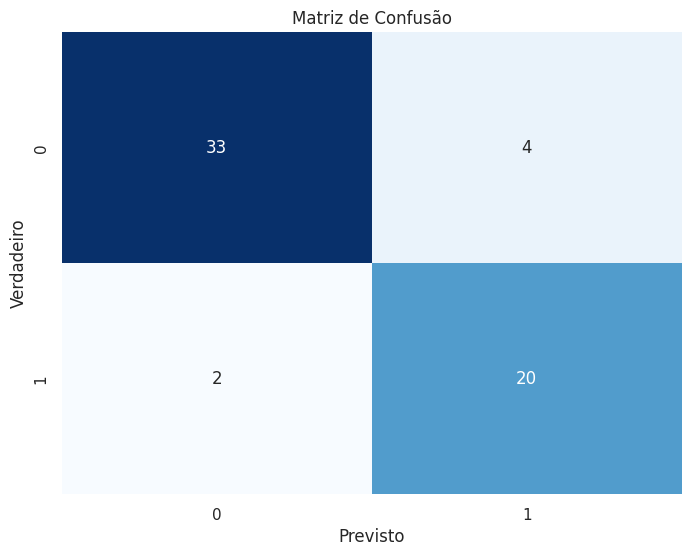

In [30]:
y_pred = mlp_classifier.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.2f}")
print("Classification Report")
print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

##Salvar como PDF


In [31]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pandoc is already the newest version (2.9.2.1-3ubuntu2).
pandoc set to manually installed.
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-latex-recommended texlive-pictures texlive-plain-generic tipa
  xfonts-encodings xfonts-utils
Suggested packages:


In [32]:
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/Mini-projeto-MLP.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Mini-projeto-MLP.ipynb to PDF
[NbConvertApp] Support files will be in Mini-projeto-MLP_files/
[NbConvertApp] Making directory ./Mini-projeto-MLP_files
[NbConvertApp] Making directory ./Mini-projeto-MLP_files
[NbConvertApp] Making directory ./Mini-projeto-MLP_files
[NbConvertApp] Making directory ./Mini-projeto-MLP_files
[NbConvertApp] Making directory ./Mini-projeto-MLP_files
[NbConvertApp] Making directory ./Mini-projeto-MLP_files
[NbConvertApp] Making directory ./Mini-projeto-MLP_files
[NbConvertApp] Making directory ./Mini-projeto-MLP_files
[NbConvertApp] Making directory ./Mini-projeto-MLP_files
[NbConvertApp] Writing 214309 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvert